What is 1/f noise?
===============
------------------------------------

**1/f noise is a correlated noise source. Its name comes from the charasteristic power spectral density that such a noise produces, which falls off towards higher frequencies (this consequently makes 1/f noise more of a problem for larger spatial frequencies). In principle, 1/f noise shows that things are less stable over bigger timescales. A sketch of the 'typical' shape of the Power Spectral Density (PSD) distribution is given below:**

<img src="./tutorials_im/oof_PSD.jpg" alt="oof PSD" width="400"/>

Where does 1/f noise come from?
===========================
------------------------------------------------------

**Detector electronics. We don't really have exact explanations for the sources of 1/f noise aside from detector-induced noise that occurs even in the absence of any signal. This could come from many sources of variations in the detector system, such as the presence of surface currents. What we do know is that 1/f noise is pertinent for data in many fields (i.e. biology, black holes). Because of this, there has been extensive literature on treatment for 1/f noise. The Reduce One Over F noise (ROOF) team wants to study these treatments found in previous literature and find relevant applications to reduce 1/f noise in transiting exoplanet data from JWST.**

How is 1/f noise relevant for JWST data?
=================================
---------------------------------------------------------------------------

**To visualize what 1/f noise looks like in our JWST data, the script ``generate_frame.py`` from the ROOF repository in the ERS-transit github (https://github.com/ers-transit/ROOF) can be run on your own, or the following explicit calls can be made**

**See the bottom of this notebook for a break-down on data structure and the JWST language of 'groups', 'frames', and 'integrations'**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from astropy.io import fits
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sys.path.append('../../ROOF')
import roof.utils as generate

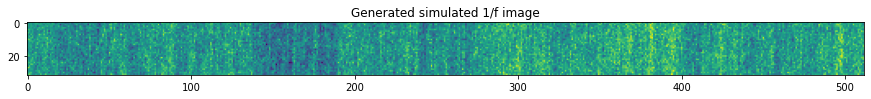

In [3]:
beta = 1.
sigma_w = 10. # counts
sigma_flicker = 10. # counts
columns = 512 # physical size of data
rows = 32 # physical size of data

times, flattened_frame, frame = generate.generate_detector_ts(beta, sigma_w, sigma_flicker, columns = columns, rows = rows)

fig=plt.figure(figsize = (15, 10))
plt.title('Generated simulated 1/f image')
plt.imshow(frame)

**The image above includes and accounts for white noise, but what does 1/f noise look on its own?**

What about other sources of noise?
==============================
------------------------------------------------------------

**If you see in the picture above, unlike white noise, 1/f noise has visible stratification. In order to understand the difference between white noise and 1/f noise, we can use the same package to display it.**

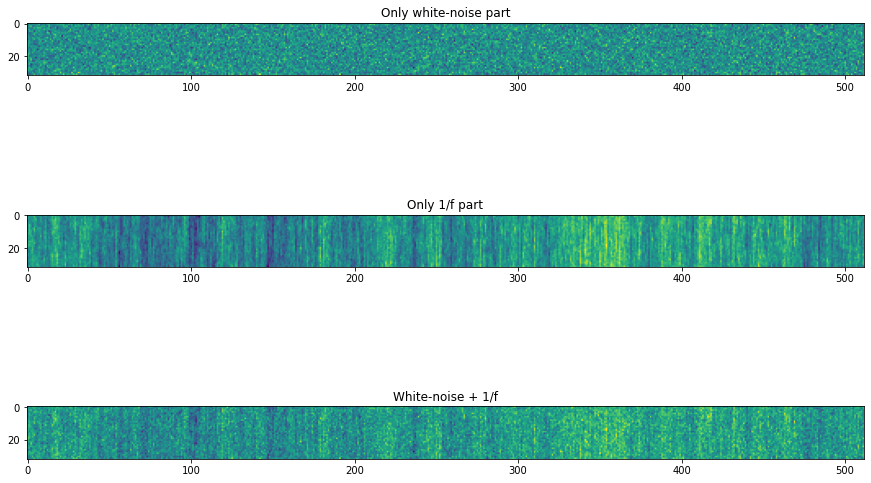

In [4]:
times, flattened_frame, frame, wn_frame = generate.generate_detector_ts(beta, sigma_w, sigma_flicker, columns = columns, rows = rows, return_white_noise = True)

fig=plt.figure(figsize = (15, 10))
plt.subplot(311)
plt.title('Only white-noise part')
plt.imshow(wn_frame)

plt.subplot(312)
plt.title('Only 1/f part')
plt.imshow(frame - wn_frame)

plt.subplot(313)
plt.title('White-noise + 1/f')
plt.imshow(frame)

How do we inject signal into the data generated above?
=============================================
-----------------------------------------------------------------------------------------

**If we want to study the effects of 1/f noise on observed data, we'll eventually want to study it as it affects simulated data. We can inject a 'ramp' (signal) into a single pixel at row 15 and column 300 on the 'data' shown above utilizing the same package**

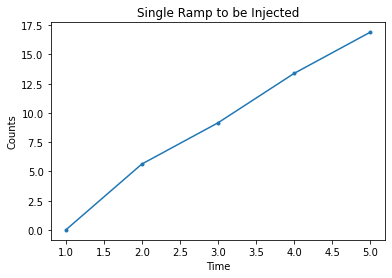

In [5]:
# Now, generate image with a ramp:
slope = 25. # Slope is in electrons per second
frametime = 0.226 # Frame time is in seconds
ngroups = 5
gain = 1.42 # Gain is in e/adu

# Output is in counts:
ramp = generate.gen_ramp(slope = slope, ngroups = ngroups, gain = gain, frametime = frametime)

group_number = np.arange(ngroups) + 1
plt.title("Single Ramp to be Injected")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.plot(group_number, ramp, '.-')

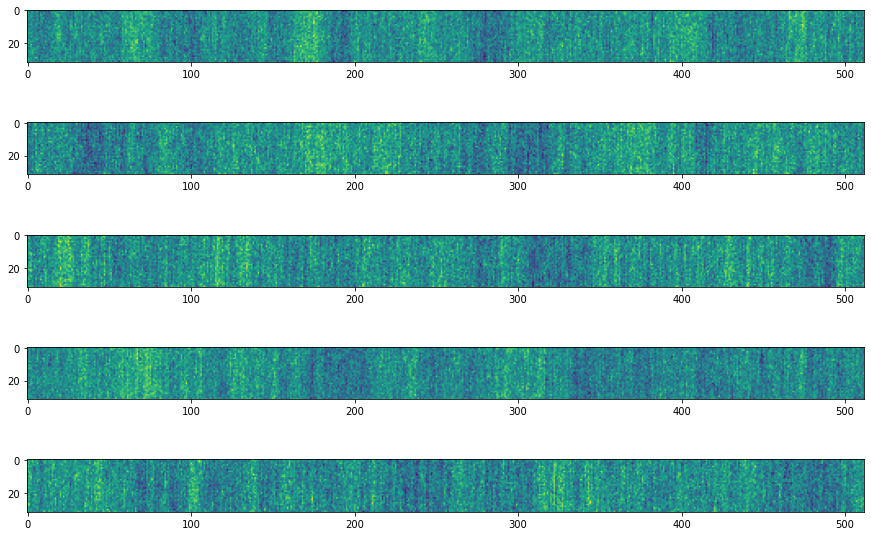

In [6]:
# Now add this ramp to simulationns of the 1/f noise to simulate an integration:
simulated_groups = np.zeros([ngroups, rows, columns])

fig=plt.figure(figsize = (15, 10))
for i in range(ngroups):

    plt.subplot(ngroups*100 + 10 + (i+1))
    _, _, simulated_groups[i, :, :] = generate.generate_detector_ts(beta, sigma_w, sigma_flicker, columns = columns, rows = rows)

    simulated_groups[i, 15, 300] += ramp[i]
    plt.imshow(simulated_groups[i, :, :])


**It is clear from the images above that 1/f noise can be a big source of noise in comparison to injected data, this is why the ROOF team is working on this!**

How do we treat 1/f noise?
======================
------------------------------------------------------

**There are several ways to treat 1/f noise, and these are being explored by the ROOF team**

**should we add a break down here?**

Load in Data
============
------------------------------------

**The following was written in order for people to understand the data structure of JWST and provide a straightforward way of visualizing the data in python (in case you're used to using DS9 like me but you want something that can interface with your code too)**

In [7]:
readin = fits.open("tutorials_data/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits")

Read Data Shape
==============
--------------------------------------------

**Going into the data blind might be a bit overwhelming, but understanding things such as the shape and structure of your data might be helpful in understanding what you're working with!**

In [8]:
#to look at the headers yourself do: readin[0].header and/or readin[1].header

print("DATA SHAPE: {}\n".format(np.shape(readin[1].data)))
print("NUMBER OF INTEGRATIONS: {}\n".format(readin[0].header["NINTS"]))
print("NUMBER OF GROUPS: {}\n".format(readin[0].header["NGROUPS"]))
print("NUMBER OF FRAMES PER GROUP (fetched from header info): {}\n".format(readin[0].header["NFRAMES"]))
print("NUMBER OF ROWS: {}\n".format(np.shape(readin[1].data)[2]))
print("NUMBER OF COLUMNS: {}\n".format(np.shape(readin[1].data)[3]))

DATA SHAPE: (10, 3, 32, 512)

NUMBER OF INTEGRATIONS: 10

NUMBER OF GROUPS: 3

NUMBER OF FRAMES PER GROUP (fetched from header info): 1

NUMBER OF ROWS: 32

NUMBER OF COLUMNS: 512



Display Data from File
=================
----------------------------------

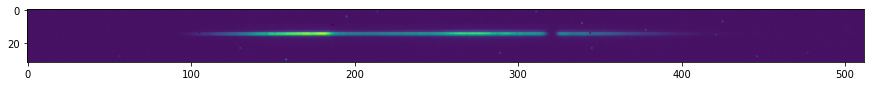

In [9]:
fig=plt.figure(figsize = (15, 10))
ax=plt.subplot(111)
ax.imshow(readin[1].data[0,1])

Playground Visualization of Data Structure!
====================================

**The following is just a fun visualization of the data structure for educational purposes in order to showcase what groups vs integrations are! Feel free to play around with this**

In [10]:
# setup x,y meshgrid for 3D visualizations (traditional matplotlib implementation)
X=[x for x in range(0,32)]
Y=[y for y in range(0,512)]
xx,yy=np.meshgrid(Y, X)

# setup data spaced with offsets in order to make it visually appealing
zz=readin[1].data[0,0]
zz1=readin[1].data[0,1]+500000
zz2=readin[1].data[0,2]+500000*2

zz3=readin[1].data[1,0]+1000000+500000*3
zz4=readin[1].data[1,1]+1000000+500000*4
zz5=readin[1].data[1,2]+1000000+500000*5

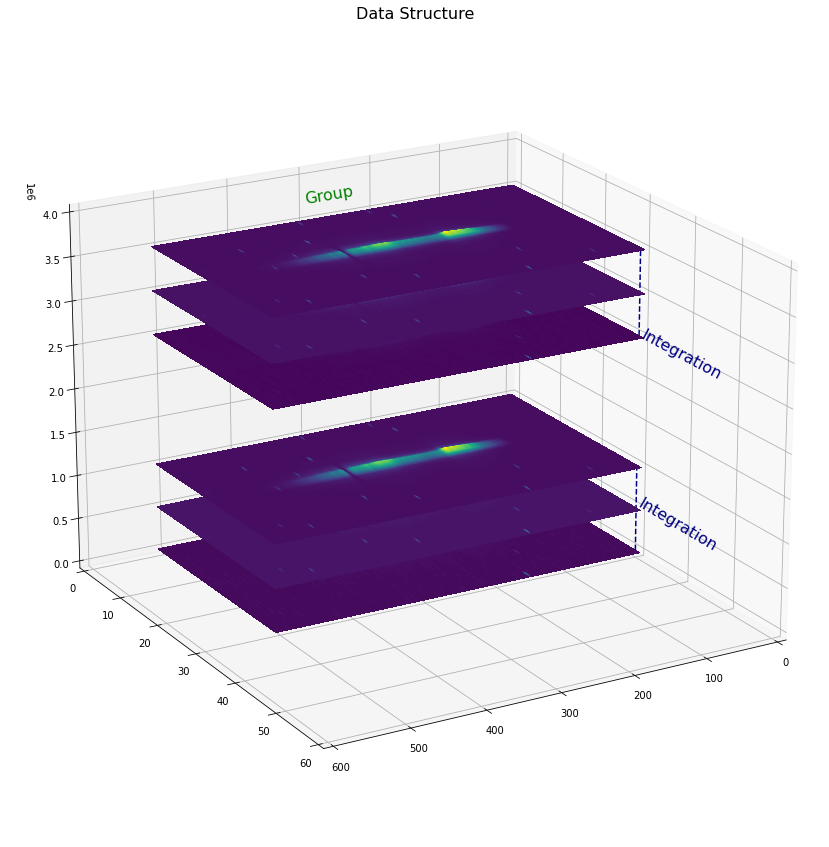

In [11]:
# setup figure object
fig2=plt.figure(figsize = (20, 15))
ax2 = fig2.gca(projection='3d')
ax2.set_title("Data Structure", size=16)

# plot contours
ax2.contourf(xx, yy, zz, levels=200)
ax2.contourf(xx, yy, zz1, levels=200)
ax2.contourf(xx, yy, zz2, levels=200)

ax2.contourf(xx, yy, zz3, levels=200)
ax2.contourf(xx, yy, zz4, levels=200)
ax2.contourf(xx, yy, zz5, levels=200)

# set axis limits and rotation
ax2.set_zlim(0,1000000*3+500000*2)
ax2.set_xlim(0,600)
ax2.set_ylim(0,60)
ax2.view_init(20, 60)

# draw annotation lines
line1x=np.linspace(0,1e6,50)
line2x=np.linspace(2.5e6,3.5e6,50)
linez=np.full((50),30)
liney=np.full((50,),0)
ax2.plot(liney, linez, line1x, zdir='z', color='navy', linestyle='--')
ax2.plot(liney, linez, line2x, zdir='z', color='navy', linestyle='--')

# draw annotation text 
zdirs = ('y', 'y')
xs = (0, 0,)
ys = (30, 30,)
zs = (0, 2000000,)

for zdir, x, y, z in zip(zdirs, xs, ys, zs):
    label = 'Integration'
    ax2.text(x, y, z, label, zdir, color='navy', size=16)
    
zdirs = ('x',)
xs = (300,)
ys = (0,)
zs = (3.7e6,)
      
for zdir, x, y, z in zip(zdirs, xs, ys, zs):
    label = 'Group'
    ax2.text(x, y, z, label, zdir, color='green', size=16)
    